## 1. Постановка задачи

Задача машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте, вы заказываете такси из одной точки Нью-Йорка в другую, причем конечная точка не обязательно должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь, время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 

Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Во время выполнения проекта мы отработаем навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения.

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [84]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head(10)

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Посмотрим на временные рамки, в которых мы работаем с данными. Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда.

In [85]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(f"{taxi_data['pickup_datetime'].dt.date.min()} to {taxi_data['pickup_datetime'].dt.date.max()}")

2016-01-01 to 2016-06-30


Посмотрим на пропуски.

In [86]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Как видим, пропусков в данных нет, то есть одной проблемой стало меньше.

Посмотрим на статистические характеристики некоторых признаков.

In [87]:
round(taxi_data.describe())

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.0,1458644,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0
mean,2.0,2016-04-01 10:10:24.940037120,2.0,-74.0,41.0,-74.0,41.0,959.0
min,1.0,2016-01-01 00:00:17,0.0,-122.0,34.0,-122.0,32.0,1.0
25%,1.0,2016-02-17 16:46:04.249999872,1.0,-74.0,41.0,-74.0,41.0,397.0
50%,2.0,2016-04-01 17:19:40,1.0,-74.0,41.0,-74.0,41.0,662.0
75%,2.0,2016-05-15 03:56:08.750000128,2.0,-74.0,41.0,-74.0,41.0,1075.0
max,2.0,2016-06-30 23:59:39,9.0,-61.0,52.0,-61.0,44.0,3526282.0
std,0.0,NaN,1.0,0.0,0.0,0.0,0.0,5237.0


* В нашей таблице представлены данные о 2 таксопарках.

* Максимальное количество пассажиров за одну поездку составляет 9 человек.

* Средняя длительность поездки равна 959 секундам, что составляет почти 16 минут.

* Медианная длительность поездки равна 662 секундам или 11 минутам.

Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы. 

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

На основе полученной статистической информации о целевом признаке trip_duration мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как усечённое среднее, логарифмическое среднее или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.

Так как все манипуляции над данными мы будем применять как с тренировочным, так и с тестовым набором данных, во избежание дублирования кода мы будем производить предобработку с помощью функций.

Начнём с временных характеристик. Как нам уже известно, хранить дату и время в формате datetime как категориальный признак редко имеет смысл, поэтому их разбивают на отдельные признаки. Эти признаки могут как стать основными факторами при построении модели, так и быть вспомогательными для извлечения информации из других таблиц.

Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начало поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [88]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

taxi_data = add_datetime_features(taxi_data)
print("Среднее количество поездок в день:", round(taxi_data.shape[0] / taxi_data['pickup_date'].nunique()))

Среднее количество поездок в день: 8015


От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

Давайте добавим в наш датасет информацию о том, является ли день праздничным. Для этого у нас есть датасет holiday_data.csv с датами всех праздничных дней в Америке за 2016 год.

В 2016 году в США было 14 праздничных дней, список которых вы можете видеть ниже:

In [89]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

In [90]:
def add_holiday_features(df1, df2):
    df2['date'] = pd.to_datetime(df2['date']).dt.date
    lst = df2['date'].tolist()
    df1['pickup_holiday'] = df1['pickup_date'].apply(lambda x: 1 if x in lst else 0)
    return df1

taxi_data = add_holiday_features(taxi_data, holiday_data)
print(f"Медианная длительность поездки в праздники: {round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())} секунд")

Медианная длительность поездки в праздники: 585 секунд


Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Воспользуемся заранее подготовленным датасетом из OSRM API для каждой поездки из нашей тренировочной выборки. Набор данных представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* id — идентификатор поездки;
* total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

In [91]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [92]:
def add_osrm_features(df1, df2):
    df1 = df1.merge(df2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], left_on='id', right_on='id', how='left')
    return df1

taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

В результате объединения таблиц у нас получились пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Воспользуемся следующими функциями:

* get_haversine_distance — функция для вычисления расстояния по формуле гаверсинуса (в километрах);
* get_angle_direction — функция для вычисления угла направления движения (в градусах).

Каждая из функций имеет четыре аргумента:
* lat1 и lng1 — векторы-столбцы с широтой и долготой первой точки;
* lat2 и lng2 — векторы-столбцы с широтой и долготой второй точки.

In [93]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [94]:
def add_geographical_features(df):
    df['havers_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df

taxi_data = add_geographical_features(taxi_data)

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Наша гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

In [95]:
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, n_init=10, random_state=42)

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации, и возвращает обновленную таблицу с добавленным в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [96]:
def add_cluster_features(df, kmeans):
    df['geo_cluster'] = kmeans.predict(coords)
    return df

taxi_data = add_cluster_features(taxi_data, kmeans)

Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

Воспользуемся заранее подготовленным датасетом с информацией о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:
* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

In [97]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,NaN,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,NaN,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,NaN,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,NaN,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,NaN,Overcast,2015-12-31,6


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [98]:
def add_weather_features(df1, df2):
    df2['date'] = pd.to_datetime(df2['time']).dt.date
    df2['hour'] = pd.to_datetime(df2['time']).dt.hour
    df1 = df1.merge(df2, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    df1.drop(columns=['time', 'windchill', 'heat index','humidity', 'pressure', 'dew Point', 'wind dir', 'gust speed', 'conditions', 'date', 'hour'], axis=1, inplace=True)
    return df1

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.isnull().sum()

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_date                 0
pickup_hour                 0
pickup_day_of_week          0
pickup_holiday              0
total_distance              1
total_travel_time           1
number_of_steps             1
havers_distance             0
direction                   0
geo_cluster                 0
temperature             12032
visibility              12032
wind speed              12032
precip                  12032
events                1387217
dtype: int64

В результате объединения у нас получились записи пропуски в столбцах temperature, visibility, wind speed, precip и events. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить. В результате добавления новой информации у нас появились пропущенные значения в данных. Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.

Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам.

In [99]:
def fill_null_weather_data(df):
    col1 = ['temperature', 'visibility', 'wind speed', 'precip']
    df[col1] = df[col1].fillna(df.groupby('pickup_date')[col1].transform('median'))
    
    df['events'] = df['events'].fillna('None')
    
    col2 = ['total_distance', 'total_travel_time', 'number_of_steps']
    df[col2] = df[col2].fillna(df[col2].median())
    return df

taxi_data = fill_null_weather_data(taxi_data)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


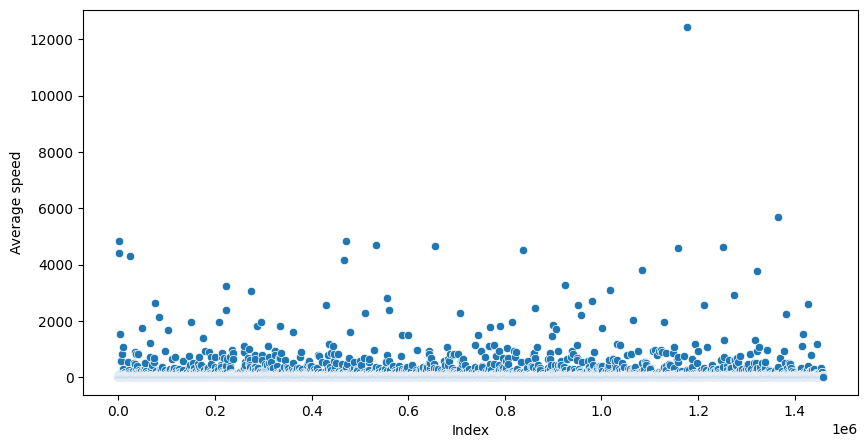

In [100]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

&rarr; Мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Найдем поездки, длительность которых превышает 24 часа, и удалим их из набора данных.

In [101]:
taxi_data = taxi_data[(taxi_data['trip_duration'] <= 24*60*60)]

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

In [102]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
taxi_data = taxi_data[avg_speed <= 300]

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [103]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 

<Axes: xlabel='trip_duration_log'>

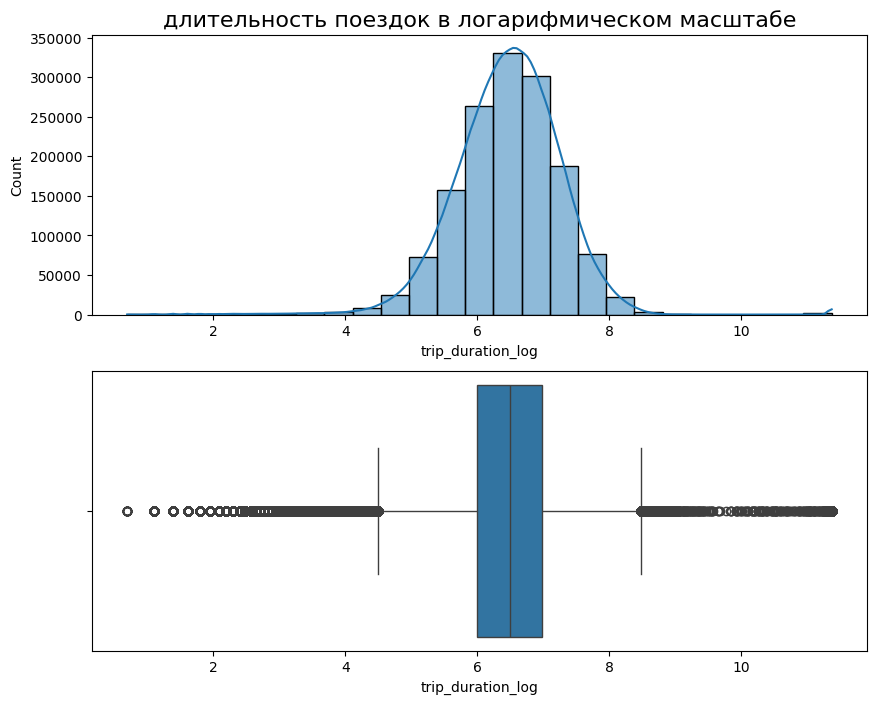

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('длительность поездок в логарифмическом масштабе', fontsize=16)
sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    width=0.9
)


p-value = 0.000
Распределение не нормальное


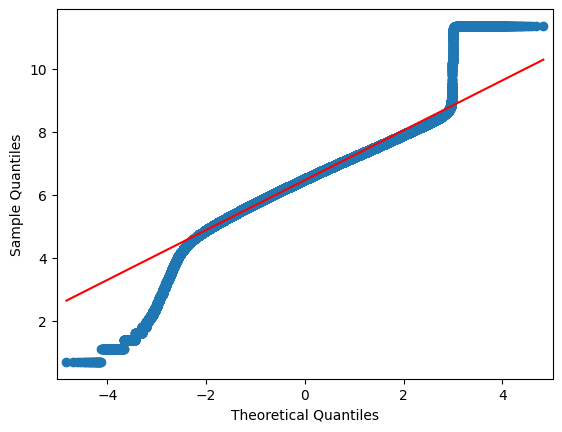

In [105]:
import statsmodels.api as sm
import scipy.stats as stats

# задаём параметры квантиль-квантиль графика
sm.qqplot(taxi_data['trip_duration_log'], line='s')

# задаём уровень значимости
alpha = 0.05 

# проводим тест Д’Агостино-Пирсона
_, p = stats.normaltest(taxi_data['trip_duration_log'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Наши выборочные значений могут иметь хвосты слева и справа, и также значения могут становится разреженными.

 На основе данных графика можно сделать вывод, что значения могут быть и не подчинены нормальному закону распределения.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

<Axes: xlabel='trip_duration_log', ylabel='vendor_id'>

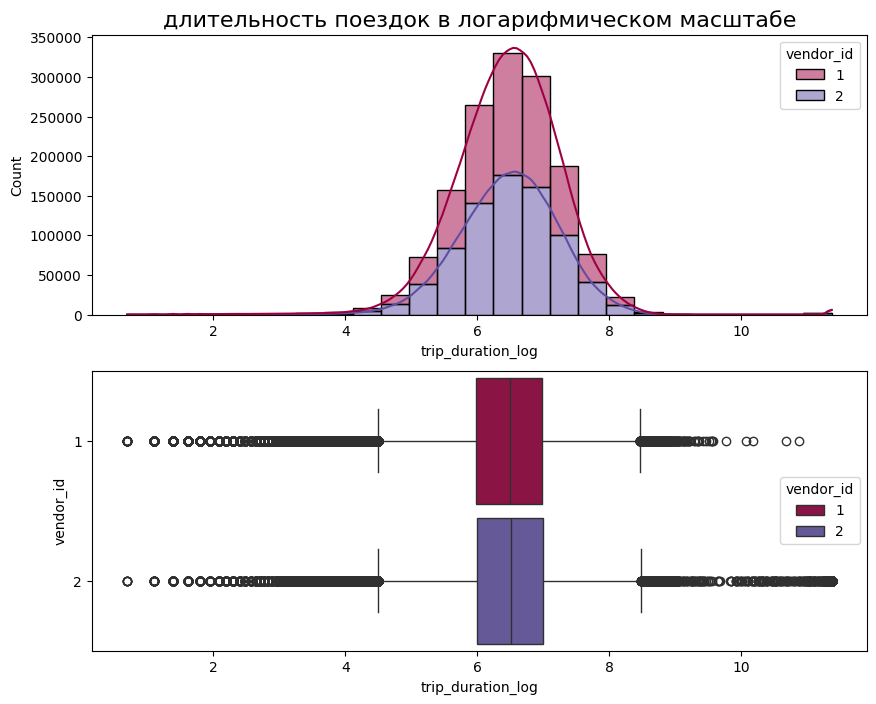

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    hue='vendor_id',
    multiple='stack',
    palette="Spectral",
    ax=axes[0]
);
axes[0].set_title('длительность поездок в логарифмическом масштабе', fontsize=16)
sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='vendor_id',
    orient='h',
    hue='vendor_id',
    palette="Spectral",
    width=0.9
)


Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

<Axes: xlabel='trip_duration_log', ylabel='store_and_fwd_flag'>

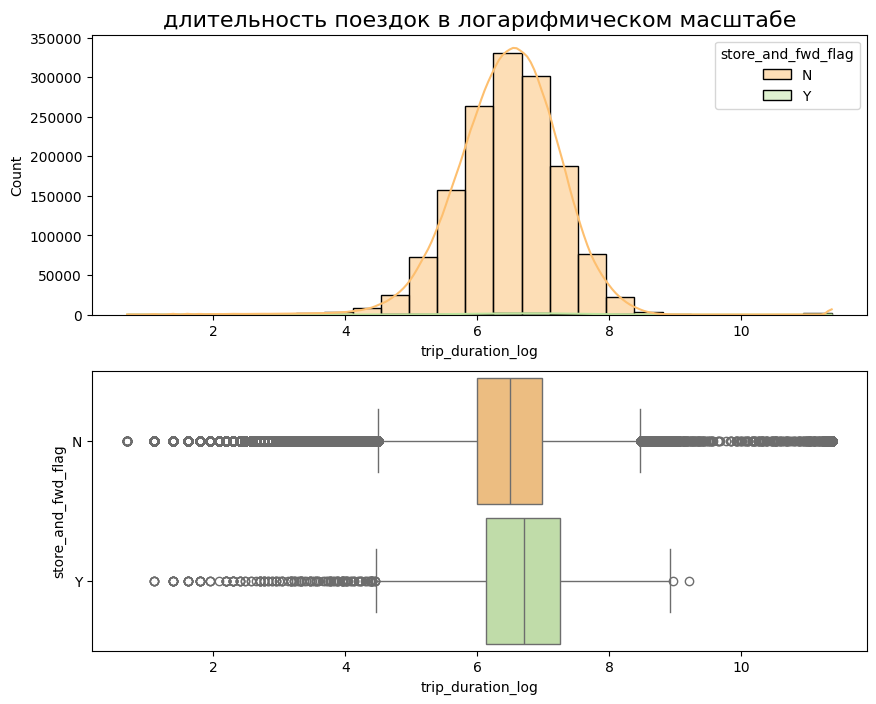

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    bins=25,
    kde=True,
    hue='store_and_fwd_flag',
    multiple='stack',
    palette="Spectral",
    ax=axes[0]
);
axes[0].set_title('длительность поездок в логарифмическом масштабе', fontsize=16)
sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    orient='h',
    hue='store_and_fwd_flag',
    palette="Spectral",
    width=0.9
)


Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

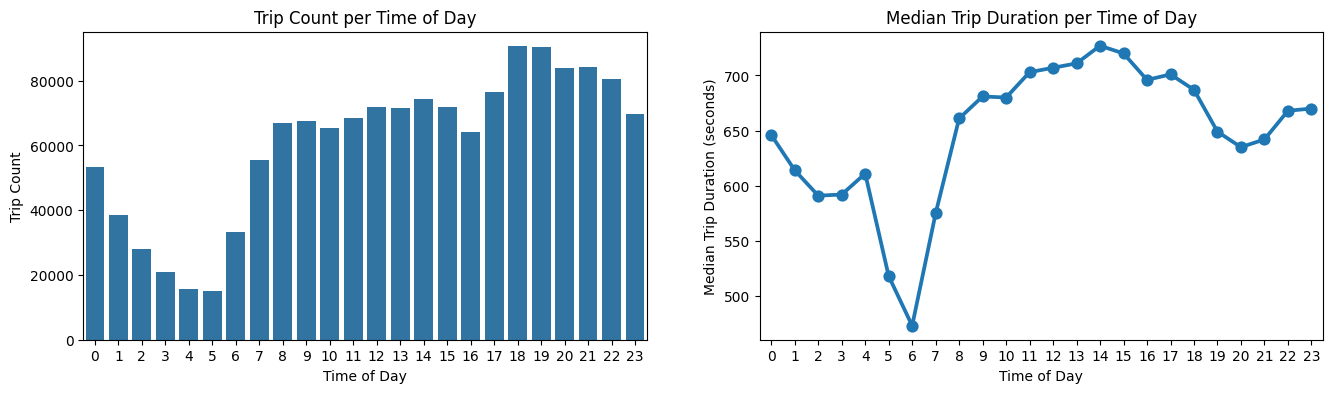

In [108]:
plt.figure(figsize=(16, 4))

ax1 = plt.subplot(1,2,1)
sns.countplot(taxi_data, x='pickup_hour')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Trip Count')
plt.title('Trip Count per Time of Day')

ax2 = plt.subplot(1,2,2)
data = taxi_data.groupby('pickup_hour').trip_duration.median().reset_index()
sns.pointplot(x='pickup_hour', y='trip_duration', data=data)
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Median Trip Duration (seconds)')
ax2.set_title('Median Trip Duration per Time of Day');

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


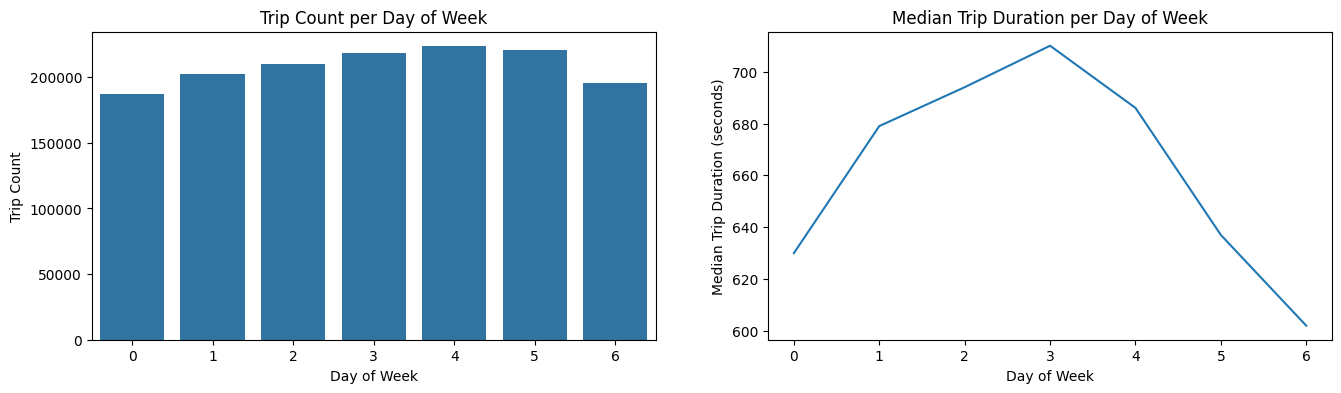

In [109]:
plt.figure(figsize=(16, 4))

ax1 = plt.subplot(1,2,1)
sns.countplot(taxi_data, x='pickup_day_of_week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Trip Count')
ax1.set_title('Trip Count per Day of Week')

ax2 = plt.subplot(1,2,2)
data = taxi_data.groupby('pickup_day_of_week').trip_duration.median().reset_index()
sns.lineplot(x='pickup_day_of_week', y='trip_duration', data=data)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Median Trip Duration (seconds)')
ax2.set_title('Median Trip Duration per Day of Week');


### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

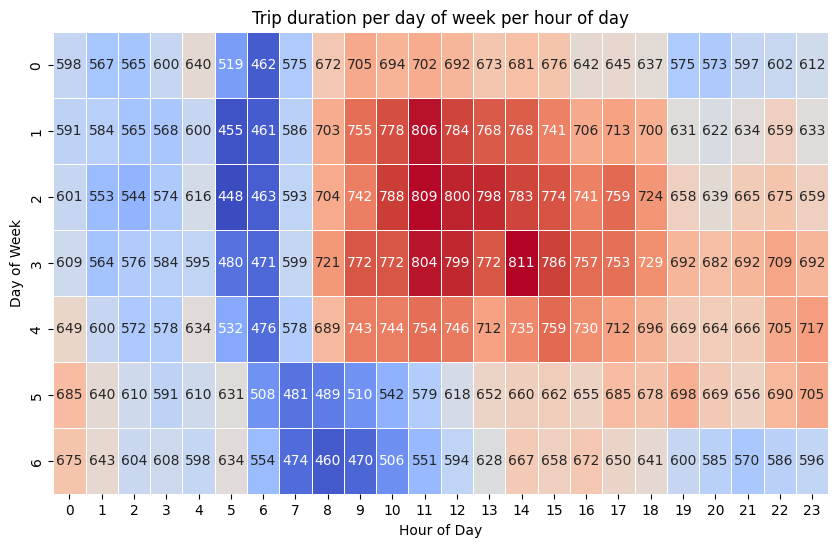

In [110]:
table = pd.pivot_table(
    taxi_data, 
    values='trip_duration', 
    columns='pickup_hour',
    index='pickup_day_of_week', 
    aggfunc="median"
)

plt.figure(figsize=(10,6))
ax = sns.heatmap(table, annot=True, fmt='.0f', cmap='coolwarm', linewidths='0.5', cbar=False)
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.title('Trip duration per day of week per hour of day');

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


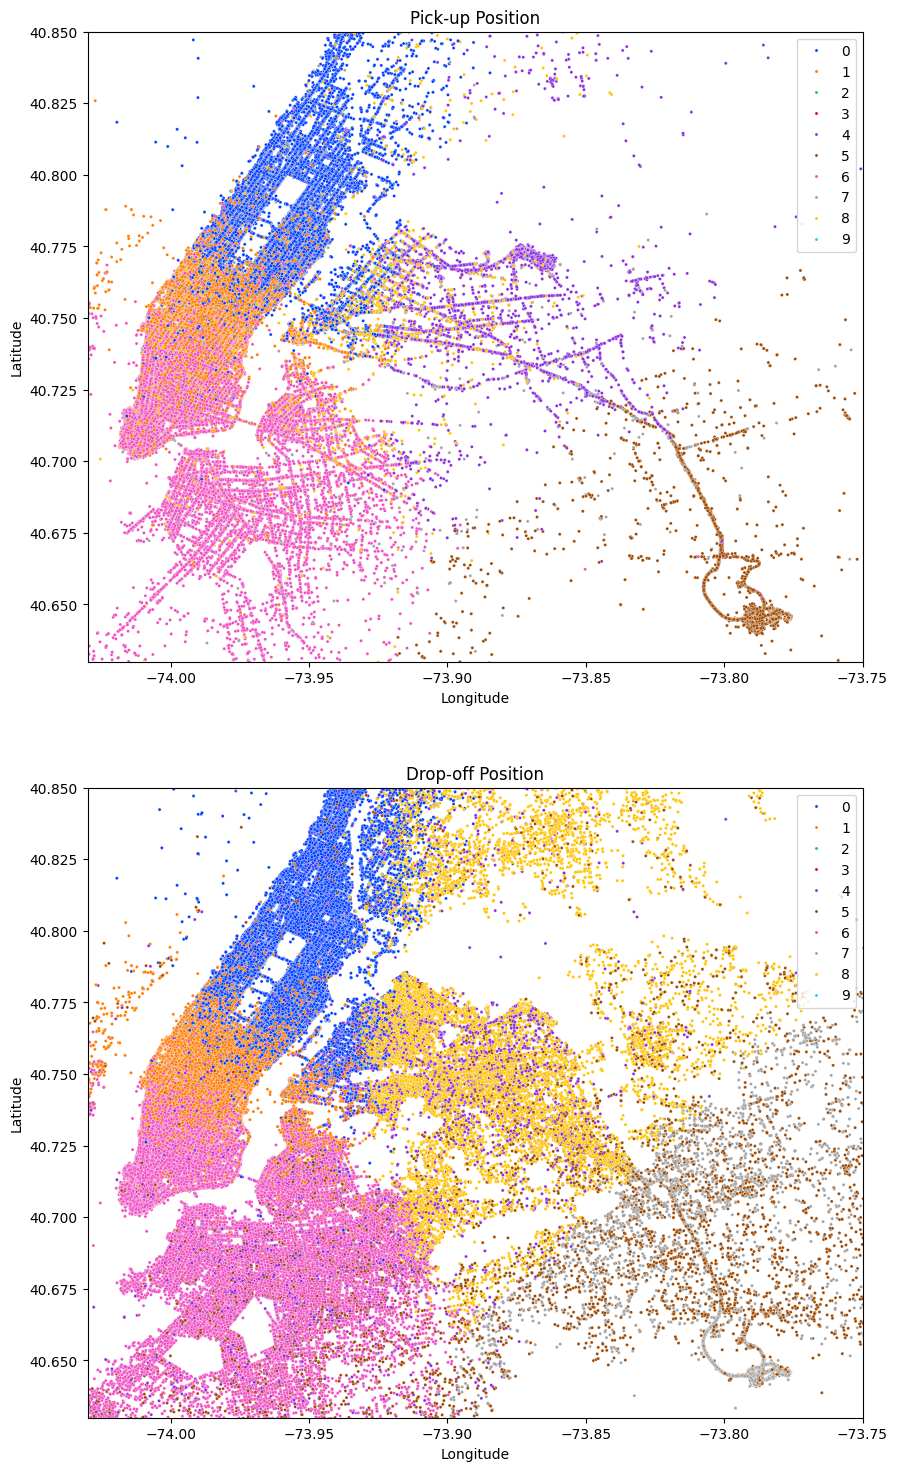

In [111]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize = (10, 18))

ax1 = plt.subplot(2,1,1)
sns.scatterplot(
    taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    s=5,
    palette='bright'
)
ax1.set_title('Pick-up Position')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_xlim(city_long_border)
ax1.set_ylim(city_lat_border)
ax1.legend(loc='upper right')

ax2 = plt.subplot(2,1,2)
sns.scatterplot(
    taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    s=5,
    palette='bright'
)
ax2.set_title('Drop-off Position')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_xlim(city_long_border)
ax2.set_ylim(city_lat_border)
ax2.legend(loc='upper right');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


Для удобства работы сделаем копию исходной таблицы с поездками:

In [112]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,havers_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:

In [113]:
drop_columns = ['pickup_datetime', 'pickup_date', 'dropoff_datetime', 'id']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

* vendor_id;
* store_and_fwd_flag;
* pickup_day_of_week;
* geo_cluster;
* events.

Первые два (vendor_id и store_and_fwd_flag) из них являются бинарными (имеют два уникальных значения).

Закодируем признак vendor_id таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

In [114]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [115]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

Так как признаки pickup_day_of_week, geo_cluster, events являются номинальными,  для них отлично подойдёт однократное кодирование.

В параметре handle_unknown установим значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

In [116]:
from sklearn.preprocessing import OneHotEncoder

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = OneHotEncoder(drop='first')
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])

column_names = one_hot_encoder.get_feature_names_out()

data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [117]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns=columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [118]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)

y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать hold-out-валидацию. Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и времязатратным.

Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [119]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. В тренировочной и валидационной выборках оставим только полученные 25 признаков, откинув ненужные. Далее мы будем работать и строить модели на отобранных признаках.

In [120]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out().tolist()

X_train = X_train[best_features]
X_valid = X_valid[best_features]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 

Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn.

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

In [122]:
X_valid_scaled['vendor_id'].mean()

0.5354341180797852

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Мы будем использовать метрику RMSLE (Root Mean Squared Log Error) для измерения качества наших моделей:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Для начала воспользуемся самой простой моделью регрессии, которая нам известна — классическая линейная регрессия по методу OLS.

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_log)
y_train_pred = lin_reg.predict(X_train_scaled)
y_valid_pred = lin_reg.predict(X_valid_scaled)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2))

Train RMSLE: 0.54
Valid RMSLE: 0.54


Теперь давайте попробуем уменьшить ошибку прогноза, воспользовавшись полиномиальной регрессией. Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn.

In [39]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train_log)
y_train_pred = lin_reg.predict(X_train_poly)
y_valid_pred = lin_reg.predict(X_valid_poly)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2))

Train RMSLE: 0.47
Valid RMSLE: 0.69


&rarr; Наблюдаются признаки переобучения в нашей модели.

Чтобы исправить проблему переобучения, попробуем воспользоваться регуляризацией. Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову).

In [41]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_poly, y_train_log)
y_train_pred = ridge.predict(X_train_poly)
y_valid_pred = ridge.predict(X_valid_poly)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2))

Train RMSLE: 0.48
Valid RMSLE: 0.48


&rarr; Модель полиномиальной регрессии с L2-регуляризацией показывает лучший результат, чем классическая модель линейной регрессии по методу OLS.

Еще одной из простейших моделей, которой мы попробуем воспользоваться, будет дерево решений.

In [42]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train_scaled, y_train_log)
y_train_pred = dtr.predict(X_train_scaled)
y_valid_pred = dtr.predict(X_valid_scaled)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2))

Train RMSLE: 0.0
Valid RMSLE: 0.56


&rarr; Модель сильно переобучена.

Мы знаем, что обучение дерева решений без ограничения его глубины практически всегда приводит к переобучению. Давайте попробуем подобрать оптимальную глубину дерева.

In [43]:
max_depths = range(7, 20)
train_scores = []
valid_scores = []
for depth in max_depths:
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr.fit(X_train_scaled, y_train_log)
    y_train_pred = dtr.predict(X_train_scaled)
    y_valid_pred = dtr.predict(X_valid_scaled)
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)))

Построим линейные графики изменения метрики RMSLE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

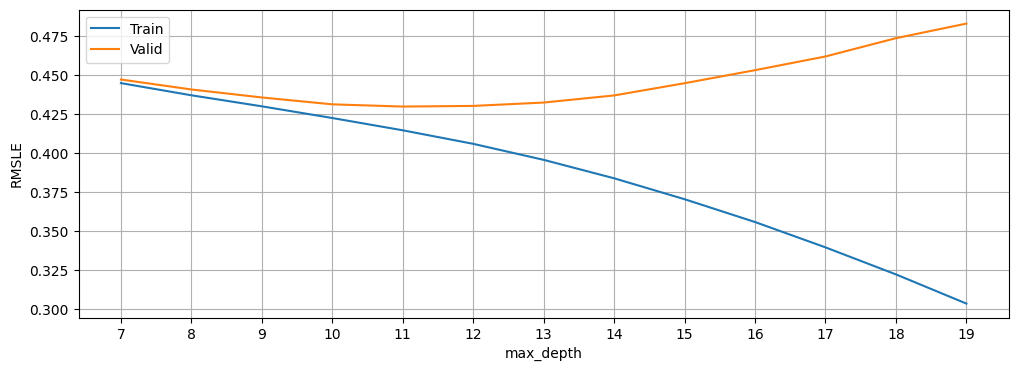

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(max_depths, train_scores, label='Train')
ax.plot(max_depths, valid_scores, label='Valid')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depths)
ax.grid()
ax.legend();

&rarr; Оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом ещё не будет наблюдаться переобучение (валидационная кривая ещё не начинает возрастать), соответствует max_depth = 12.

Обучим модель с оптимальным значением максимальной глубины дерева.

In [45]:
dtr = DecisionTreeRegressor(max_depth=12, random_state=42)
dtr.fit(X_train_scaled, y_train_log)
y_train_pred = dtr.predict(X_train_scaled)
y_valid_pred = dtr.predict(X_valid_scaled)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(2))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(2))

Train RMSLE: 0.41
Valid RMSLE: 0.43


&rarr; Модель дерева решений с оптимальным значением глубины показало наилучший результат метрики RMSLE.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

Итак, начинаем со случайного леса.

In [46]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1,
    verbose=True
)
rfr.fit(X_train_scaled, y_train_log)
y_train_pred = rfr.predict(X_train_scaled)
y_valid_pred = rfr.predict(X_valid_scaled)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(4))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


Train RMSLE: 0.3992
Valid RMSLE: 0.414


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.8s finished


&rarr; Благодаря параллельному обучению нескольких деревьев, модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Посмотрим, что будет при последовательном ансамблировании.

In [125]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    learning_rate=0.5,  
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42,
    verbose=True
)
gbr.fit(X_train_scaled, y_train_log)
y_train_pred = gbr.predict(X_train_scaled)
y_valid_pred = gbr.predict(X_valid_scaled)

print("Train RMSLE:", np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)).round(4))
print("Valid RMSLE:", np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)).round(4))

      Iter       Train Loss   Remaining Time 
         1           0.3110            7.83m
         2           0.2247            7.69m
         3           0.1985            7.57m
         4           0.1873            7.49m
         5           0.1818            7.42m
         6           0.1783            7.33m
         7           0.1749            7.30m
         8           0.1718            7.22m
         9           0.1705            7.17m
        10           0.1693            7.07m
        20           0.1595            6.23m
        30           0.1540            5.42m
        40           0.1505            4.63m
        50           0.1475            3.86m
        60           0.1457            3.06m
        70           0.1433            2.28m
        80           0.1409            1.52m
        90           0.1393           45.43s
       100           0.1380            0.00s
Train RMSLE: 0.3715
Valid RMSLE: 0.393


Теперь давайте посмотрим на важность факторов для наилучшей ансамблевой модели. Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

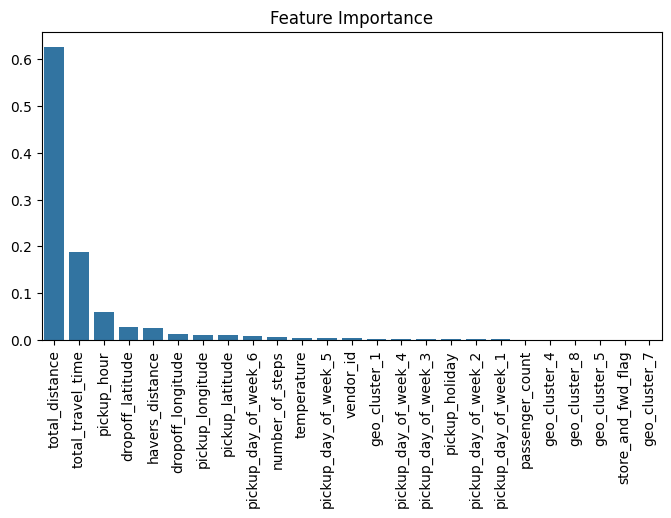

In [126]:
df = pd.DataFrame({'feature': gbr.feature_names_in_, 'importance': gbr.feature_importances_}).sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot(df, x='feature', y='importance')
ax.set_title('Feature Importance')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=90)

&rarr; Топ-3 факторов, наиболее значимых для предсказания целевого признака (длительности поездки) в логарифмическом масштабе: 
* _total_distance_
* _total_travel_time_
* _pickup_hour_

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Нам хотелось бы понять, насколько наша итоговая модель хорошо предсказывает целевой признак с точки зрения бизнес-процесса. Точнее, мы бы хотели получить более понятное представление об ошибке прогноза длительности поездки.

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

In [48]:
# переводим значения из логарифмического масштаба в истинный
y_valid_exp = np.exp(y_valid_log) - 1
y_valid_pred_exp = np.exp(y_valid_pred) - 1

print(f"Valid MeAE: {(metrics.median_absolute_error(y_valid_exp, y_valid_pred_exp)/60).round(1)} mins")

Valid MeAE: 1.8 mins


Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [123]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [124]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
coords = np.hstack((test_data[['pickup_latitude', 'pickup_longitude']],
                    test_data[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(coords)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


**Финальный шаг** - предсказание для отложенного тестового набора данных. 

In [133]:
y_test_predict = rfr.predict(X_test_scaled)
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.9s finished


В завершение по ансамблевым методам попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: 
* повышенная производительность путем параллелизации процесса обучения, 
* повышенное качество решения за счет усовершенствования алгоритма бустинга, 
* меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

In [127]:
# Импортируем библиотеку
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [128]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [129]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 
            'eta': 0.1, 
            'colsample_bytree': 0.9, 
            'max_depth': 6, 
            'subsample': 0.9, 
            'lambda': 1, 
            'nthread': -1, 
            'booster' : 'gbtree', 
            'eval_metric': 'rmse', 
            'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=30 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74193
[30]	train-rmse:0.42617	valid-rmse:0.42916
[60]	train-rmse:0.40896	valid-rmse:0.41286
[90]	train-rmse:0.40131	valid-rmse:0.40613
[120]	train-rmse:0.39658	valid-rmse:0.40223
[150]	train-rmse:0.39374	valid-rmse:0.40021
[180]	train-rmse:0.39081	valid-rmse:0.39809
[210]	train-rmse:0.38872	valid-rmse:0.39690
[240]	train-rmse:0.38684	valid-rmse:0.39567
[270]	train-rmse:0.38522	valid-rmse:0.39482
[299]	train-rmse:0.38366	valid-rmse:0.39415


&rarr; Наилучший результат (наименьшее значение RMSLE на валидационной выборке) среди всех моделей показал градиентный бустинг над деревьями решений.


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


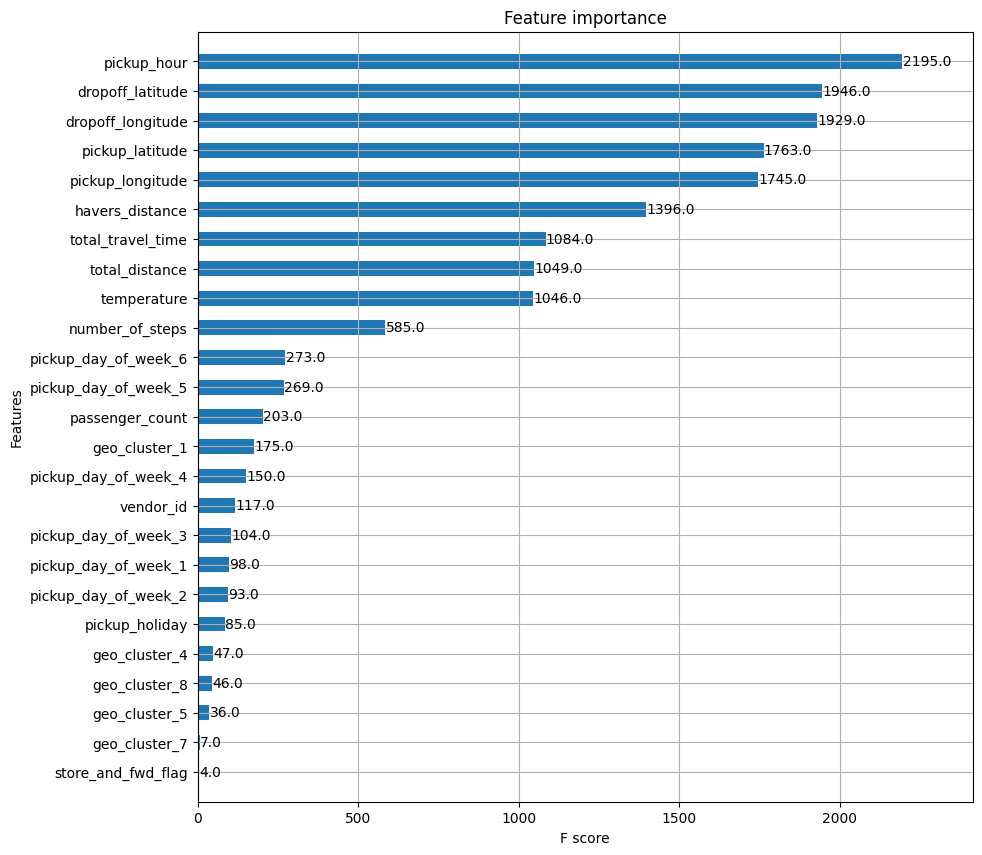

In [130]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model, ax=ax, height=0.5);

* Отметим, что результаты важности факторов по XGBoost отличаются от GradientBoostingRegressor.

**Финальный шаг** - предсказание для отложенного тестового набора данных. 

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

In [131]:
# Делаем предсказание на тестовом наборе данных
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39415


После того как предсказание длительности поездок на тестовой выборке cформировано, мы можем создать submission-файл в формате CSV, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

In [132]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_xgb.csv', index=False)

Результат метрики RMSLE на валидационной выборке модели GradientBoostingRegressor немного лучше, чем у XGBoost. Однако, загрузив submission-файлы на основе обеих моделей на Kaggle, было обнаружено, что XGBoost сработал немного лучше на тестовой выборке, чем GradientBoostingRegressor.